In [1]:
import os

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
cuda = torch.cuda.is_available()
import numpy as np

In [3]:
import torchvision
from PIL import Image

In [17]:
def parse_data(datadir):
    img_list = []
    ID_list = []
    file_list = []
    for root, directories, filenames in os.walk(datadir):
          
          for filename in filenames:
              file_list.append(filename)
              if filename.endswith('.png'):
                  filei = os.path.join(root, filename)
                  img_list.append(filei)
                  ID_list.append(root.split('/')[-1])

    # construct a dictionary, where key and value correspond to ID and target
    uniqueID_list = list(set(ID_list))
    class_n = len(uniqueID_list)
    target_dict = dict(zip(uniqueID_list, range(class_n)))
    label_list = [target_dict[ID_key] for ID_key in ID_list]
    
    

    print('{}\t\t{}\n{}\t\t{}'.format('#Images', '#Labels', len(img_list), len(set(label_list))))
    return img_list, label_list, class_n

In [18]:
img_list, label_list, class_n = parse_data("cohn-kanade-trunc")

#Images		#Labels
0		0


In [19]:
class ImageDataset(Dataset):
    def __init__(self, file_list, target_list):
        self.file_list = file_list
        self.target_list = target_list
        self.n_class = len(list(set(target_list)))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img = Image.open(self.file_list[index])
        img_pil = torchvision.transforms.Resize((224,224))(img)
        img = torchvision.transforms.ToTensor()(img_pil)
        if img.shape[0] == 3:
            img = torchvision.transforms.Grayscale(num_output_channels=1)(img_pil)
            img = torchvision.transforms.ToTensor()(img)
        label = self.target_list[index]
        return img, label

In [20]:

dataset = ImageDataset(img_list,label_list)

In [21]:
len(dataset)

0

In [22]:
for i in range(1779):
    print(dataset[i][0].shape)

IndexError: list index out of range

In [23]:
train_dataset, dev_dataset = torch.utils.data.random_split(dataset, (1000,779))

ValueError: Sum of input lengths does not equal the length of the input dataset!

In [11]:
# for i in range(len(train_dataset)):
#     print(train_dataset[i][0].shape)

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, 
                                               shuffle=True, num_workers=8)

In [13]:
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=64, 
                                               shuffle=True, num_workers=8)

In [4]:
class AttentionLayer(nn.Module):
    def __init__(self, input1, input2):
        super(AttentionLayer, self).__init__()
        
        self.input1 = input1
        self.input2 = input2
        
        self.batch, self.outchannel1, self.h1, self.w1 = input1.shape
        self.batch, self.outchannel2 = input2.shape

        self.attention_fclayer = nn.Linear(self.outchannel2, self.outchannel1)
        
    def forward(self):
        
        input2_rescaled = self.attention_fclayer(self.input2)
        compat_scores = torch.zeros((self.batch, self.h1*self.w1))

        for h in range(self.h1):
            for w in range(self.w1):
                compat_scores[h*self.w1+w] = torch.bmm(self.input1[:,:,h,w].view(self.batch,1,self.outchannel1), input2_rescaled.view(self.batch,self.outchannel1,1))
        
        normalized_compat_scores = F.softmax(compat_scores)
        
        g_mod = torch.bmm(normalized_compat_scores.view(self.batch,1,self.h1*self.w1).repeat(1,self.outchannels1,1).view(self.batch,self.outchannels1,1,self.h1*self.w1),
                          self.input1.view(self.batch,self.outchannels1,self.h1*self.w1,1))
        
        return g_mod

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
                          nn.Conv2d(in_channels=C_in, out_channels=C_out, kernel_size=kernel_size, stride=stride),
                          nn.ReLU(),
                          nn.MaxPool2d(2))
        
    def forward(self, x):
        return self.block(x)
    
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class BaselineModel(nn.Module):
    def __init__(self, num_blocks):
        super(BaselineModel, self).__init__()
        layers = []
        self.num_classes = 13
        channels = [1, 64, 128, 256] # this needs to be modified according to num_blocks
        
        convlayer1 = ConvBlock(C_in=channels[0], C_out=channels[1], kernel_size=5, stride=1)
        convlayer2 = ConvBlock(C_in=channels[1], C_out=channels[2], kernel_size=5, stride=1)
        convlayer3 = ConvBlock(C_in=channels[2], C_out=channels[3], kernel_size=5, stride=1)
        
#         for i in range(num_blocks):
#             layers.append(ConvBlock(C_in=channels[i], C_out=channels[i+1], kernel_size=5, stride=1))
        
        dropoutlayer1 = nn.Dropout(p=0.25)
        
#         layers.append(nn.Dropout(p=0.25))
        
        flattenlayer = Flatten()
        
#         layers.append(Flatten())
        
        fclayer1 = nn.Linear(256*24*24, 512)
        
#         layers.append(nn.Linear(256*24*24, 512))
        
        dropoutlayer2 = nn.Dropout(p=0.5)
        
#         layers.append(nn.Dropout(p=0.5))
        
#         fclayer2 = nn.Linear(512, num_classes)
        
#         layers.append(nn.Linear(512, num_classes))
        
#         self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        out1 = convlayer1(x)
        out2 = convlayer2(out1)
        out3 = convlayer3(out2)
        out4 = dropoutlayer1(out3)
        out5 = flattenlayer(out4)
        out6 = fclayer1(out5)
        out7 = dropoutlayer2(out6)
        
        attlayer1 = AttentionLayer(out1,out7)
        attlayer2 = AttentionLayer(out2,out7)
        attlayer3 = AttentionLayer(out3,out7)
        
        attout1 = attlayer1.forward()
        attout2 = attlayer2.forward()
        attout3 = attlayer3.forward()
        
        attout = torch.cat((attout1,attout2,attout3),1)
        
        _, att_size = attout.shape
        
        fclayer2 = nn.Linear(att_size, self.num_classes)
        final_out = fclayer2(attout)
        
        return attout
        
#         return self.net(x)

In [6]:
model = BaselineModel(num_blocks=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
device = torch.device("cuda" if cuda else "cpu")
print(model)

ValueError: optimizer got an empty parameter list

In [16]:
def train(model,n_epochs,train_dataloader, test_loader):
    model.train()
    model.to(device)
    train_losses = []
    eval_losses = []
    eval_accs = []
    for epoch in range(n_epochs):
        avg_loss = 0.0
        for batch_num, (feats, labels) in enumerate(train_dataloader):
            feats, labels = feats.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(feats)
            loss = criterion(outputs, labels.long())
            loss.backward()
            
            optimizer.step()
            
            avg_loss += loss.item()
            if batch_num % 50 == 49:
                print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
                logging.debug('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
                avg_loss = 0.0    
        
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        train_losses.append(avg_loss)
        test_loss, test_accuracy = test_classify_loss(model,test_loader)
        eval_losses.append(test_loss)
        eval_accs.append(test_accuracy)
        print('Epoch: {}\tTrain Loss: {}\tTest-Loss: {}\tTest-acc: {:.4f}'.format(epoch+1, avg_loss, test_loss, test_accuracy))
    return train_losses, eval_losses, eval_accs

def test_classify_loss(model, test_loader):
    with torch.no_grad():
        model.eval()
        test_loss = []
        accuracy = 0
        total = 0
        for batch_num, (feats, labels) in enumerate(test_loader):
            feats, labels = feats.to(device), labels.to(device)
            outputs = model(feats)
            _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
            pred_labels = pred_labels.view(-1)
            loss = criterion(outputs, labels.long())
            accuracy += torch.sum(torch.eq(pred_labels, labels)).item()
            total += len(labels)
            test_loss.extend([loss.item()]*feats.size()[0])
            torch.cuda.empty_cache()
            del feats
            del labels
    model.train()
    return np.mean(test_loss), accuracy/total

In [17]:
train_losses, eval_losses, eval_accs = train(model,200, train_dataloader,dev_dataloader)

Epoch: 1	Train Loss: 63.02754461765289	Test-Loss: 2.197271955487664	Test-acc: 0.1951
Epoch: 2	Train Loss: 34.255574345588684	Test-Loss: 2.087508680272623	Test-acc: 0.1874
Epoch: 3	Train Loss: 33.47430980205536	Test-Loss: 2.035364953176966	Test-acc: 0.1887
Epoch: 4	Train Loss: 33.30989921092987	Test-Loss: 2.0281211479025414	Test-acc: 0.1630
Epoch: 5	Train Loss: 33.05229163169861	Test-Loss: 2.0194760417142485	Test-acc: 0.1951
Epoch: 6	Train Loss: 33.383405566215515	Test-Loss: 2.049062414867122	Test-acc: 0.1938
Epoch: 7	Train Loss: 33.11706733703613	Test-Loss: 2.131909435000438	Test-acc: 0.1913
Epoch: 8	Train Loss: 33.97400486469269	Test-Loss: 2.0283821264188617	Test-acc: 0.1913
Epoch: 9	Train Loss: 33.10310983657837	Test-Loss: 2.0222603766694762	Test-acc: 0.1836
Epoch: 10	Train Loss: 32.44009470939636	Test-Loss: 2.01141713244006	Test-acc: 0.1656
Epoch: 11	Train Loss: 32.517762541770935	Test-Loss: 2.007597753876134	Test-acc: 0.1733
Epoch: 12	Train Loss: 32.40723371505737	Test-Loss: 2.0677

Epoch: 96	Train Loss: 0.8577483389526606	Test-Loss: 2.489312084862754	Test-acc: 0.8062
Epoch: 97	Train Loss: 0.7897922731935978	Test-Loss: 2.221649663898238	Test-acc: 0.8049
Epoch: 98	Train Loss: 1.1278361082077026	Test-Loss: 2.405091494441377	Test-acc: 0.8049
Epoch: 99	Train Loss: 0.8412737846374512	Test-Loss: 2.3307851352495774	Test-acc: 0.8074
Epoch: 100	Train Loss: 0.6021096855401993	Test-Loss: 2.5781964998649234	Test-acc: 0.8087
Epoch: 101	Train Loss: 0.33426270820200443	Test-Loss: 2.608663726985378	Test-acc: 0.8074
Epoch: 102	Train Loss: 0.44082098302897066	Test-Loss: 2.412385626843101	Test-acc: 0.8036
Epoch: 103	Train Loss: 0.8207991756498814	Test-Loss: 2.1519355876454953	Test-acc: 0.8010
Epoch: 104	Train Loss: 0.6097771618515253	Test-Loss: 2.442733457370569	Test-acc: 0.7972
Epoch: 105	Train Loss: 0.7070735804736614	Test-Loss: 2.2321162692083476	Test-acc: 0.7997
Epoch: 106	Train Loss: 0.554950412362814	Test-Loss: 2.6642157342834865	Test-acc: 0.8036
Epoch: 107	Train Loss: 0.77818

Epoch: 189	Train Loss: 0.4835682064294815	Test-Loss: 2.5915546772263083	Test-acc: 0.7972
Epoch: 190	Train Loss: 0.574068583548069	Test-Loss: 2.9636481417311935	Test-acc: 0.8113
Epoch: 191	Train Loss: 0.4528897777199745	Test-Loss: 2.3686141355658985	Test-acc: 0.8010
Epoch: 192	Train Loss: 0.4885578602552414	Test-Loss: 3.2086004384521956	Test-acc: 0.8036
Epoch: 193	Train Loss: 0.48900020867586136	Test-Loss: 3.457954230449347	Test-acc: 0.7959
Epoch: 194	Train Loss: 0.7062461730092764	Test-Loss: 2.5764408376311767	Test-acc: 0.8074
Epoch: 195	Train Loss: 0.5861465424532071	Test-Loss: 2.6071280894444753	Test-acc: 0.8113
Epoch: 196	Train Loss: 0.29166228463873267	Test-Loss: 2.963573941829422	Test-acc: 0.8139
Epoch: 197	Train Loss: 0.3229213356971741	Test-Loss: 2.90779328835944	Test-acc: 0.8100
Epoch: 198	Train Loss: 0.6613255441188812	Test-Loss: 2.6967037861858314	Test-acc: 0.8049
Epoch: 199	Train Loss: 0.5834210533648729	Test-Loss: 2.8140170864941476	Test-acc: 0.8036
Epoch: 200	Train Loss: 0

In [20]:
import matplotlib.pyplot as plt

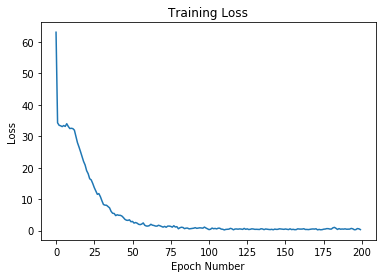

In [21]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.savefig("training_loss.png")

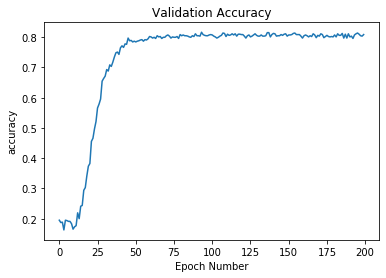

In [22]:
plt.title('Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('accuracy')
plt.plot(eval_accs)
plt.savefig("val_acc.png")